In [1]:
!pip install -q prettytable

In [2]:
from prettytable import PrettyTable


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [3]:
import warnings

warnings.filterwarnings("ignore")
# onnx for network architecture visualization
import onnx
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [4]:
from JigsawNet import JigsawNet

model = JigsawNet(n_classes=50, num_features=3072, relu_in_last_fc=True)
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |  1572864   |
|  fc1.bias  |    512     |
| fc2.weight | 301989888  |
|  fc2.bias  |   16384    |
| fc3.weight |  67108864  |
|  fc3.bias  |    4096    |
| fc4.weight |   204800   |
|  fc4.bias  |     50     |
| bn4.weight |     50     |
|  bn4.bias  |     50     |
+------------+------------+
Total Trainable Params: 370897558


370897558

In [5]:
dummy_input = torch.randn(1, 36, 3072)
input_names = ["dummy_input"]
output_names = ["dummy_output"]

In [6]:
onnx_path = "results/onnx_JigsawNet.pt"
torch.onnx.export(
    model, dummy_input, onnx_path, input_names=input_names, output_names=output_names
)
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(onnx_path)), onnx_path)
# Then go to netron.app in your browser and choose the exported file to visualize

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [7]:
# code from TA
import torch.nn as nn
import torch.nn.functional as F


# # Define the model architecture
class JigsawModel(nn.Module):
    def __init__(self, num_positions):
        super(JigsawModel, self).__init__()
        self.num_positions = num_positions
        self.fc1 = nn.Linear(36 * 2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 50)
        self.bn4 = nn.BatchNorm1d(50)  # Batch normalization after fc4

    def forward(self, x):
        x = x.view(-1, 36 * 2048)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(
            self.bn4(self.fc4(x))
        )  # Apply batch normalization after fc4 and before activation
        x = F.softmax(x, dim=1)
        return x


model = JigsawModel(num_positions=50)
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |  75497472  |
|  fc1.bias  |    1024    |
| fc2.weight |   524288   |
|  fc2.bias  |    512     |
| fc3.weight |   65536    |
|  fc3.bias  |    128     |
| fc4.weight |    6400    |
|  fc4.bias  |     50     |
| bn4.weight |     50     |
|  bn4.bias  |     50     |
+------------+------------+
Total Trainable Params: 76095510


76095510

In [8]:
dummy_input = torch.randn(1, 36, 2048)
input_names = ["dummy_input"]
output_names = ["dummy_output"]

In [9]:
onnx_path = "results/onnx_JigsawModel.pt"
torch.onnx.export(
    model, dummy_input, onnx_path, input_names=input_names, output_names=output_names
)
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(onnx_path)), onnx_path)
# Then go to netron.app in your browser and choose the exported file to visualize

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [10]:
from JigsawNet import JigsawNet

model = JigsawNet(
    n_classes=50, num_features=2048, relu_in_last_fc=True, include_softmax=True
)

onnx_path = "results/onnx_JigsawNet_2048.pt"
torch.onnx.export(
    model, dummy_input, onnx_path, input_names=input_names, output_names=output_names
)
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(onnx_path)), onnx_path)
# Then go to netron.app in your browser and choose the exported file to visualize

pytorch_total_params = sum(p.numel() for p in model.parameters())

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
pytorch_total_params

370373270

In [12]:
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |  1048576   |
|  fc1.bias  |    512     |
| fc2.weight | 301989888  |
|  fc2.bias  |   16384    |
| fc3.weight |  67108864  |
|  fc3.bias  |    4096    |
| fc4.weight |   204800   |
|  fc4.bias  |     50     |
| bn4.weight |     50     |
|  bn4.bias  |     50     |
+------------+------------+
Total Trainable Params: 370373270


370373270

In [13]:
import pandas as pd


def calc_accuracies(ground_truth_file, results_folder):
    groud_truth = pd.read_csv(ground_truth_file, header=None, delimiter=" ")
    groud_truth = groud_truth.sort_values(0).reset_index(drop=True)

    average_acc = 0
    for i in range(10):
        phase = i + 1
        phase_gt = groud_truth.loc[groud_truth[1] < 10 * phase].reset_index(drop=True)

        result = pd.read_csv(
            f"{results_folder}/result_{phase}.txt", header=None, delimiter=" "
        )
        result = result.loc[result[0].isin(phase_gt[0].values)].reset_index(drop=True)

        acc = 1 - len(result.compare(phase_gt)) / len(phase_gt)
        print(f"phase: {phase}\tacc: {acc}", flush=True)
        average_acc += acc

    return acc, average_acc / 10

In [14]:
final_acc, average_acc = calc_accuracies("reference_data/val_gt.txt", "results")
final_acc, average_acc

FileNotFoundError: [Errno 2] No such file or directory: 'reference_data/val_gt.txt'

In [ ]:
final_acc, average_acc = calc_accuracies("reference_data/test_gt.txt", "test_results")
final_acc, average_acc

phase: 1	acc: 0.9468599033816425
phase: 2	acc: 0.8701923076923077
phase: 3	acc: 0.8298555377207062
phase: 4	acc: 0.8435619735258725
phase: 5	acc: 0.8346153846153846
phase: 6	acc: 0.8351999999999999
phase: 7	acc: 0.8178082191780822
phase: 8	acc: 0.8077844311377246
phase: 9	acc: 0.7980820458177944
phase: 10	acc: 0.7954000958313369


(0.7954000958313369, 0.837935989890085)

## Submissions


### Public Leaderboard

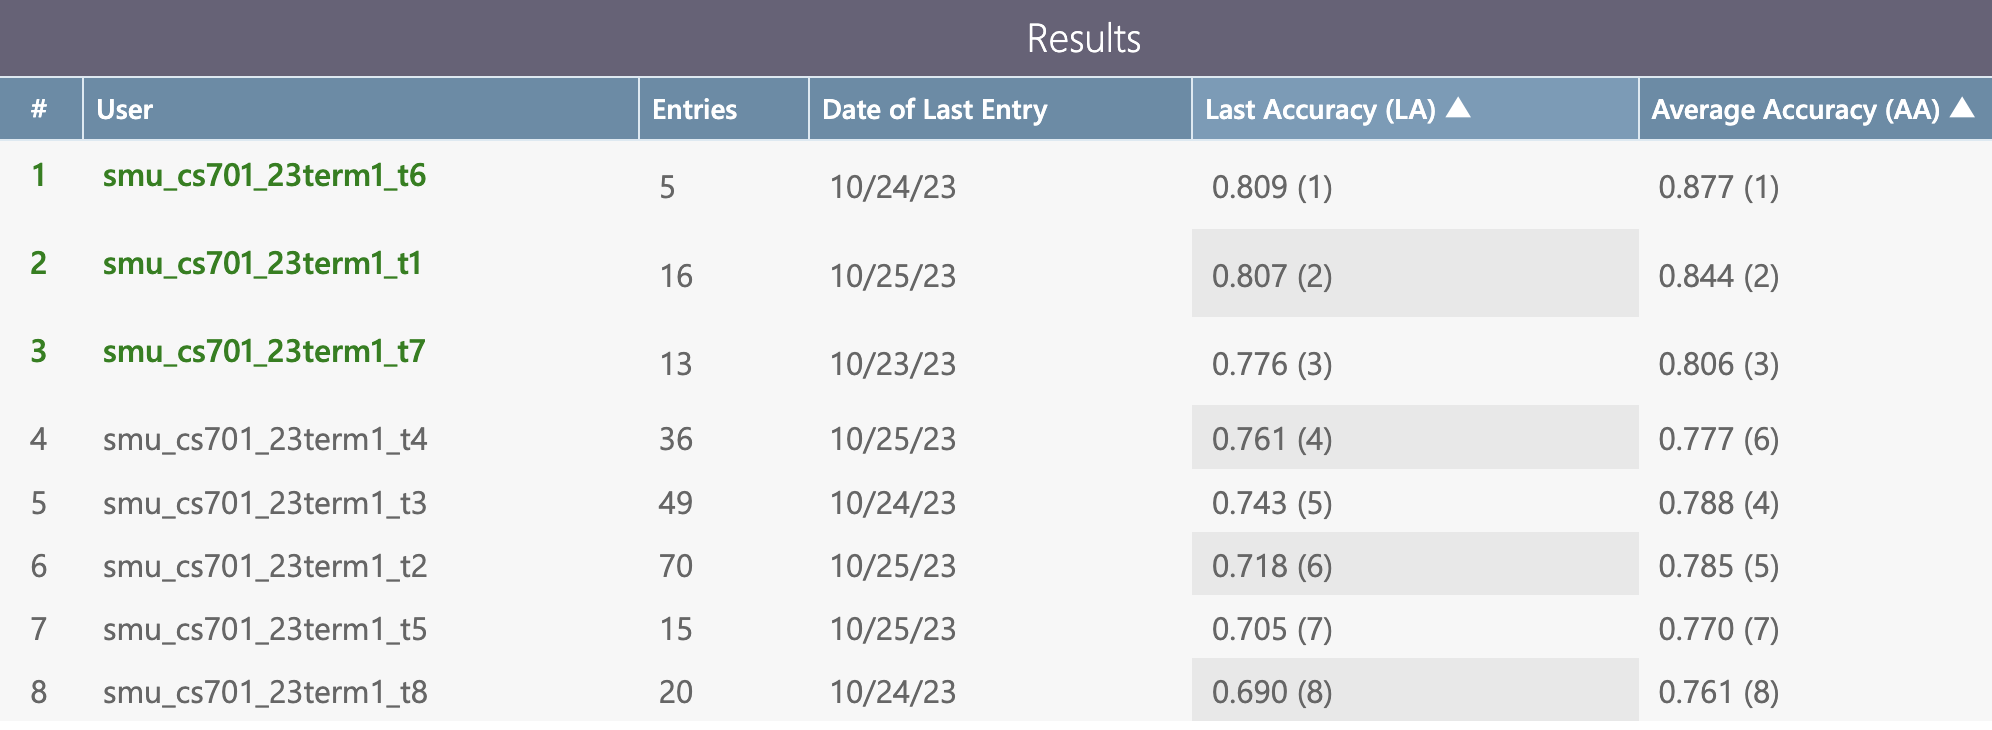


In [ ]:
final_acc, average_acc = calc_accuracies(
    "reference_data/val_gt.txt", "submissions/results"
)
final_acc, average_acc

phase: 1	acc: 0.8850574712643678


phase: 2	acc: 0.8238636363636364
phase: 3	acc: 0.7954545454545454
phase: 4	acc: 0.8210227272727273
phase: 5	acc: 0.7913832199546486
phase: 6	acc: 0.768361581920904
phase: 7	acc: 0.7435483870967742
phase: 8	acc: 0.7535211267605634
phase: 9	acc: 0.7490589711417817
phase: 10	acc: 0.7178329571106095


(0.7178329571106095, 0.7849104624340558)

### Private Leaderboard

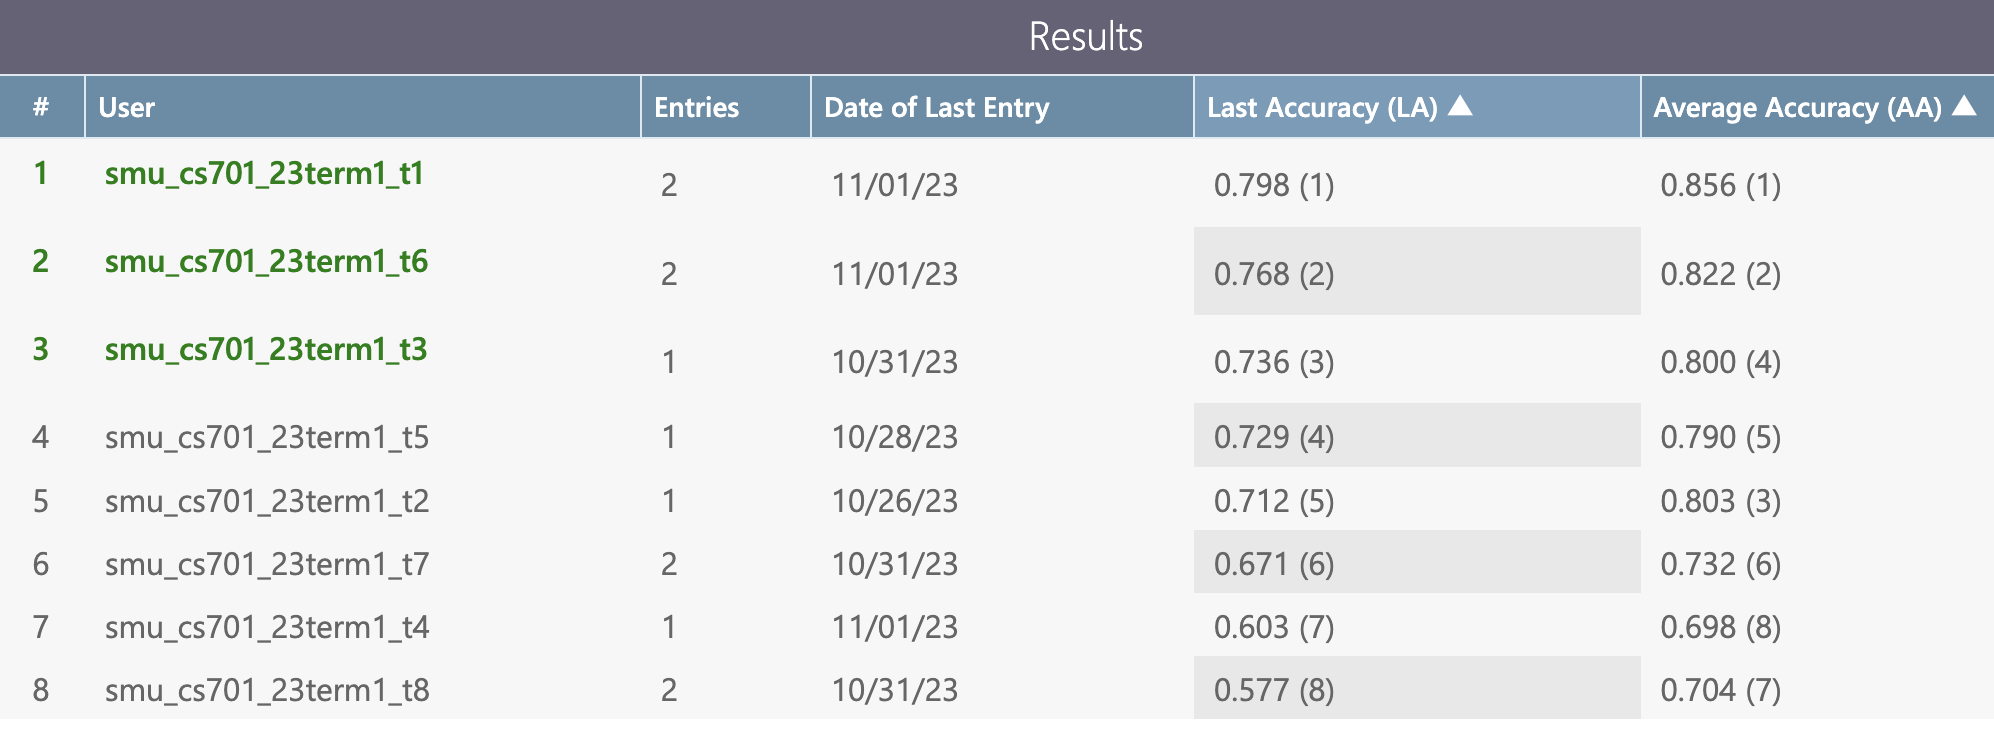


In [ ]:
final_acc, average_acc = calc_accuracies(
    "reference_data/test_gt.txt", "submissions/test_results"
)
final_acc, average_acc

phase: 1	acc: 0.9710144927536232
phase: 2	acc: 0.8581730769230769
phase: 3	acc: 0.8443017656500802
phase: 4	acc: 0.8363417569193743
phase: 5	acc: 0.7913461538461538
phase: 6	acc: 0.7792
phase: 7	acc: 0.7568493150684932
phase: 8	acc: 0.7389221556886227
phase: 9	acc: 0.7373468300479489
phase: 10	acc: 0.7115476760900814


(0.7115476760900814, 0.8025043222987455)